<a href="https://colab.research.google.com/github/kiko4902/lab4/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Feature detection (corners, edges, Hough transform)

**This command must be run before starting to do each lab.**

In [24]:
!rm -rf clone && git clone https://github.com/ferit-osirv/lab4 clone && cp -a clone/. .

Cloning into 'clone'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 19 (delta 1), reused 3 (delta 0), pack-reused 12 (from 1)
Receiving objects: 100% (19/19), 3.68 MiB | 31.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [25]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math

<h2>Edge Detection</h2>

When talking about images, the edge can be defined as a boundary between two regions with relatively distinct gray level properties.
Edges are pixels where the brightness function changes abruptly.
Edge detectors are a collection of very important local image preprocessing methods used to locate (sharpen) changes in the intensity function.
Different edge detection methods include Canny, Sobel, Roberts, SUSAN, Prewitt, and Deriche.

<h3>Edge Detection with Canny Edge descriptor</h3>

Canny Edge Detection is a popular edge detection algorithm.
This is a multi-step algorithm, so its successful performance, depends on few steps:

<ul>
  <li><b>Preprocessing (noise reduction)</b></li>
  Since all edge detection results are easily affected by image noise, it is essential to filter out the noise to prevent false detection caused by noise.
  To smooth the image, we will use a Gaussian filter.
  This step will slightly smooth the image to reduce the effects of obvious noise on the edge detector.
  The equation for a Gaussian filter with a kernel of size (2k+1) x (2k+1) is given with:

![gauss](https://wikimedia.org/api/rest_v1/media/math/render/svg/4a36d7f727beeaff58352d671bb41a3aca9f44d6)
  
  As seen from the above formula, important parameters for the Gaussian filter are:
  <ul>
    <li>size of the kernel (mostly 5x5 kernel is used)</li>
    <li>and standard deviation sigma </li>
  </ul>
  
   <p>
  <li><b>Finding intensity gradient of the image</b></li>
  An edge in an image may point in a variety of directions, so the Canny algorithm uses filters to detect horizontal, vertical and diagonal edges in the blurred image.
  The edge detection operator (such as Roberts, Prewitt, or Sobel) returns a value for the first derivative in the horizontal direction (Gx) and the vertical direction (Gy).
  In other words, <i>the magnitude</i> of the gradient at a point in the image determines if it possibly lies on the edge or not. A high gradient magnitude means the colors are changing rapidly which implies the existence of an edge while a low gradient implies that edge is not present.
  The <i>direction</i> of the gradient shows how the edge is oriented.
  To calculate these, following formulas are used:

![canny-edge-1](http://latex.codecogs.com/gif.latex?Edge%20Gradient%20%28G%29%20%3D%20%5Csqrt%7BG_x%5E2&amp;plus;G_y%5E2%7D)
![canny-edge-2](http://latex.codecogs.com/gif.latex?Angle%20%28%5Ctheta%29%20%3D%20%5Ctan%5E%7B-1%7D%5Cfrac%7BG_y%7D%7BG_x%7D)

  Once we have the gradient magnitudes and orientations, we can get started with the actual edge detection.

 </p>

 <p>
  <li><b>Applying non-maximum suppression to get rid of spurious response to the edge detection</b></li>

  After gradient magnitude and direction are obtained, a full scan of the image is done to remove any unwanted pixels which may not constitute the edge.
  Therefore, edge thining technique known as non-maximum suppression is applied to find all those unwanted pixels.
  For this, at every pixel, the pixel is checked if it is a local maximum in its neighborhood in the direction of the gradient. Check the image below:

![non-maximum](https://docs.opencv.org/3.1.0/nms.jpg)
  <br>
  Point A is on the edge ( in the vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions.
  So point A is checked with point B and C to see if it forms a local maximum. If so, it is considered for the next stage, otherwise, it is suppressed ( put to zero).
  In short, the result you get is a binary image with "thin edges".
</p>

  <li><b>Track edge by hysteresis </li></b>
  Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.
  This stage decides which are all edges are really edges and which are not. For this, we need two threshold values, minVal, and maxVal.
  Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded.
  Those who lie between these two thresholds are classified edges or non-edges based on their connectivity.
  If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded. See the image below:

![non-maximum](https://docs.opencv.org/3.1.0/hysteresis.jpg)

 <p>
    The edge A is above the maxVal, so considered as "sure-edge". Although edge C is below maxVal, it is connected to edge A, so that also considered as valid edge and we get that full curve.
    But edge B, although it is above minVal and is in the same region as that of edge C, it is not connected to any "sure-edge", so that is discarded.
    So it is very important that we have to select minVal and maxVal accordingly to get the correct result.
    This stage also removes small pixels noises on the assumption that edges are long lines. So what we finally get is strong edges in the image.
 </p>
  
</ul>

OpenCV implementation of Canny edge detector:

```
Function : cv2.Canny(blurred image,lower threshold,upper threshold)
Parameters are as follows :
1. blurred image : input image blurred with Gaussian 5 by 5 kernel
2. lower threshold : first threshold for the hysteresis procedure
3. upper threshold : second threshold for the hysteresis procedure
```
More information can be found at:  <a href="https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.canny#cv2.Canny">OpenCV cv2.Canny documentation</a>

> ### Assignment 1: Edge Detection
>
>Use the Canny edge detector on any image from the `images` directory:
>
>1. **Image Preparation:**
>   - Load the image in grayscale
>   - Apply Gaussian blur to the image
>
>2. **Edge Detection:**
>   - Apply the Canny edge detector
>   - Experiment with lower and upper threshold values (suggested range: 100-200)
>   - Adjust thresholds to achieve clear edges while minimizing noise
>
>3. **Output:**
>   - Display the original image
>   - Display the image with detected edges
>   - Document your final threshold values

In [26]:
image = cv.imread('images/building_1.jpg', cv.IMREAD_GRAYSCALE)

blurred_image = cv.GaussianBlur(image, (5, 5), 0)

In [27]:
lower_threshold = 100
upper_threshold = 180
edges = cv.Canny(blurred_image, lower_threshold, upper_threshold)

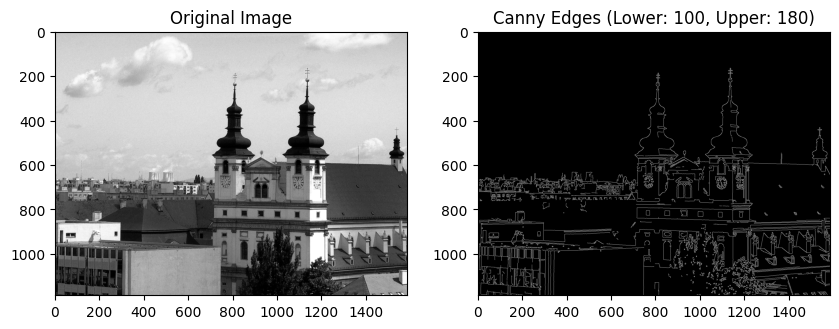

Final threshold values: Lower = 100, Upper = 180


In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title(f'Canny Edges (Lower: {lower_threshold}, Upper: {upper_threshold})')

plt.show()

print(f"Final threshold values: Lower = {lower_threshold}, Upper = {upper_threshold}")

<h3>Hough Transformation for Lines</h3>

When images are to be used in different areas of image analysis such as object recognition, it is important to reduce the amount of data in the image while preserving the important, characteristic, structural information. Edge detection makes it possible to reduce the amount of data in an image considerably. However the output from an edge detector is still a image described by its pixels. If lines, ellipses and so forth could be defined by their characteristic equations, the amount of data would be reduced even more.

The Hough transform was originally developed to recognize lines and has later been generalized to cover arbitrary shapes.

<ul>
<li> <b>Representation of Lines in the Hough Space</b> </li>

Lines can be represented uniquely by with parameters a and b and following equation:

![line-1](https://latex.codecogs.com/gif.latex?y%3Da%5Ccdot%20x%20&plus;b)

Above equation is not able to represent vertical lines. Therefore, the Hough transform uses the following equation: <br>

![line-2](https://latex.codecogs.com/gif.latex?r%20%3D%20x%20%5Ccdot%20%5Ccos%20%5CTheta%20&plus;%20y%5Ccdot%20%5Csin%20%5CTheta)

To obtain similar equation to the first one, this can be rewritten as:

![line-3](https://latex.codecogs.com/gif.latex?y%20%3D%20-%20%5Cfrac%7B%5Ccos%20%5CTheta%20%7D%7B%5Csin%20%5CTheta%20%7D%20%5Ccdot%20x%20&plus;%20%5Cfrac%7Br%7D%7B%5CTheta%20%7D)

The parameters ![line-1](https://latex.codecogs.com/gif.latex?%5Ctheta) and r is the angle of the line and the distance from the line to the origin, respectively.

All lines can be represented in this form when  <img src="https://i.ibb.co/4Sq4DkD/formula1.png" alt="hough1" border="0"></a>.

To sum up, the Hough space for lines has these two dimensions: ![line-1](https://latex.codecogs.com/gif.latex?%5Ctheta) and r and a line is represented by a single point, corresponding to a unique set of parameters ![line-1](https://latex.codecogs.com/gif.latex?%28%5Ctheta%20_%7B0%7D%2Cr_%7B0%7D%29).

The line-to-point mapping is illustrated in the following image:

<p align="center">
<img src="https://i.ibb.co/gJ9C8Jy/hough1.png" alt="hough1" border="0"></a><br /><br />
</p>

<li> <b>Mapping of edge points to the Hough space</b> </li>

An important concept for the Hough transform is the mapping of single points. The idea is, that a point is mapped to all lines, that can pass through that point.

This yields a sine-like line in the Hough space.  This principle is illustrated for a point ![formula](https://latex.codecogs.com/gif.latex?p_%7B0%7D%3D%20%2840%2C30%29)as shown in following figures:

<p align="center">
<img src="https://i.ibb.co/GVRDyJs/houghspace.png" alt="houghspace" border="0">
</p>

On the left image transformation of a single point to a line in the Hough space is shown while on the right image
the Hough space line representation through all possible lines through the point is shown.

<li><b>The Hough Space Accumulator</b></li>

To determine the areas where most Hough space lines intersect, an accumulator covering the Hough space is used. When an edge point is transformed, bins in the accumulator is incremented
for all lines that could pass through that point. The resolution of the accumulator determines the precision with which lines can be detected.

In general, the number of dimensions of the accumulator corresponds to the number of unknown parameters in the Hough transform problem. Thus, for ellipses a 5-dimensional space is required
(the coordinates of its center, the length of its major and minor axis, and its angle). For lines 2 dimensions suffice (r and θ). This is why it is possible to visualize the content of the ac
cumulator.

To sum up, the algorithm for detecting straight lines can be divided to the following steps:
<ul>
<li> Edge detection, e.g. using the Canny edge detector </li>
<li> Mapping of edge points to the Hough space and storage in an accumulator </li>
<li> Interpretation of the accumulator to yield lines of infinite length. The interpretation isdone by thresholding and possibly other constraints. </li>
<li> Conversion of infinite lines to finite lines. </li>
</ul>

More information about Hough Transformation for lines can be found at:  <a href="href> https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html">OpenCV Hough Transform documentation</a>


OpenCV implementation of Hough Transform for lines can be found in:

```
Function : cv2.HoughLines(image with edges,rho,theta,threshold, array,srn,stn)
Parameters are as follows :
1. image with edges : input image with found edges
2. rho : distance resolution of the accumulator in pixels
3. theta : angle resolution of the accumulator in radians
4. threshold: accumulator threshold parameter. only those lines are returned that get enough votes
5. array: return an empty array with shape and type of input for storing result
6. srn: for the multi-scale Hough transform, if 0 standard Hough transform is used
7. stn: for the multi-scale Hough transform, if 0 standard Hough transform is used
```
More information can be found at:  <a href="https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.hough#cv2.HoughLines">OpenCV cv2.HoughLines documentation</a>


> ### Assignment 2: Hough Transform
>
> Apply the Hough transform to the image `crossword.jpg`:
>
> 1. **Edge Detection:**
>    - Apply Gaussian blur
>    - Perform Canny edge detection
>
> 2. **Hough Transform:**
>    - Apply Hough transform to the edge image
>    - Use `draw_lines` function to draw detected lines on the **original image**
>    - Example function call:
>      ```python
>      lines = cv2.HoughLines(edges, 1, math.pi/90, 200, np.array([]), 0, 0)
>      ```
>    - Start with the parameters shown above
>    - Adjust the `threshold` parameter (currently 200) to properly detect the crossword lines
>
> 3. **Output:**
>    - Display the resulting image with detected lines

In [29]:
import math

def draw_lines(img, lines):
  a,b,c = lines.shape
  for i in range(a):
      rho = lines[i][0][0]
      theta = lines[i][0][1]
      a = math.cos(theta)
      b = math.sin(theta)
      x0, y0 = a*rho, b*rho
      pt1 = ( int(x0+1000*(-b)), int(y0+1000*(a)) )
      pt2 = ( int(x0-1000*(-b)), int(y0-1000*(a)) )
      cv.line(img, pt1, pt2, (255, 0, 0), 2, cv.LINE_AA)
  return img

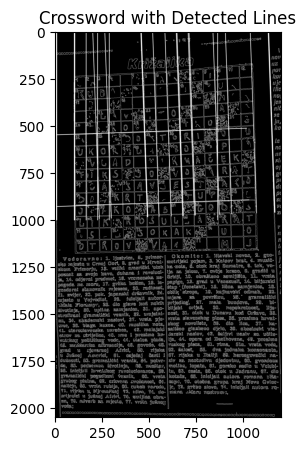

In [57]:
image = cv.imread('images/crossword.jpg', cv.IMREAD_GRAYSCALE)

blurred_image = cv.GaussianBlur(image, (5, 5), 0)

edges = cv.Canny(blurred_image, 100, 200)

lines = cv.HoughLines(edges, 1, math.pi/90, 339, np.array([]), 0, 0)

if lines is not None:
    image_with_lines = draw_lines(edges, lines)
    plt.figure(figsize=(10, 5))
    plt.imshow(image_with_lines,cmap='grey')
    plt.title('Crossword with Detected Lines')
    plt.show()
else:
    print("No lines detected.")

> ### Assignment 3: Hough Transform Parameter Analysis
>
> Use the same code as before, but set the `theta` parameter to `math.pi/180`. Observe the difference in which lines are detected.

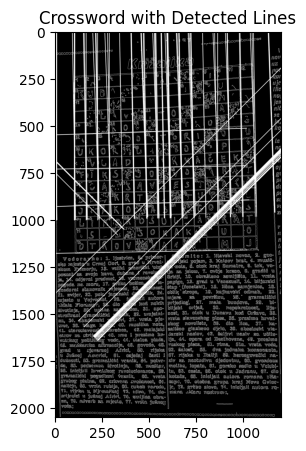

In [58]:
image = cv.imread('images/crossword.jpg', cv.IMREAD_GRAYSCALE)

blurred_image = cv.GaussianBlur(image, (5, 5), 0)

edges = cv.Canny(blurred_image, 100, 200)

lines = cv.HoughLines(edges, 1, math.pi/180, 339, np.array([]), 0, 0)

if lines is not None:
    image_with_lines = draw_lines(edges, lines)
    plt.figure(figsize=(10, 5))
    plt.imshow(image_with_lines,cmap='grey')
    plt.title('Crossword with Detected Lines')
    plt.show()
else:
    print("No lines detected.")

<h4>5.3. Corner Detection</h4>

Corners are locations in images where a slight shift in the location will lead to a large change in intensity in both horizontal and vertical axes.
The Harris Corner detection algorithm consist of following steps:

<ul>
<li><b>Determination of windows (small image patches) with large intensity variation</b></li>

Let a window (the center) be located at position  &nbsp; ![cornerr](https://latex.codecogs.com/gif.latex?%28x%2Cy%29).  &nbsp;
Let the intensity of the pixel at this location be  &nbsp; ![cornerrr](https://latex.codecogs.com/gif.latex?I%28x%2Cy%29).  &nbsp;
If this window slightly shifts to a new location with displacement  &nbsp; ![corner7](https://latex.codecogs.com/gif.latex?%28u%2Cv%29),  &nbsp; the intensity of the pixel at this location will be
 &nbsp; ![corner8](https://latex.codecogs.com/gif.latex?I%28x&plus;u%2Cy&plus;v%29).  &nbsp;

Therefore,  &nbsp; ![corner9](https://latex.codecogs.com/gif.latex?%5BI%28x&plus;u%2Cy&plus;v%29-I%28x%2Cy%29%5D)  &nbsp; will be the difference in intensities of the window shift.
For a corner, this difference will be very high.
We maximize this term by differentiating it with respect to the X and Y axes.
Let  &nbsp; ![corner10](https://latex.codecogs.com/gif.latex?w%28x%2Cy%29)  &nbsp;be the weights of pixels over a window (Rectangular or a Gaussian).
Then,  &nbsp; ![corner11](https://latex.codecogs.com/gif.latex?E%28u%2Cv%29)  &nbsp; is defined as :
<p align="center">
<img src="https://cdn-images-1.medium.com/max/800/0*v4pgxvEFE8JvroJv.png" alt="hough1" border="0"></a><br /><br />
</p>


Since,computing &nbsp; ![corner11](https://latex.codecogs.com/gif.latex?E%28u%2Cv%29)  &nbsp; will be computationally challenged, optimisation with Taylor series expansion (only the 1rst order)
is applyed. Some math leads us to: <br/>

![corner12](https://latex.codecogs.com/gif.latex?E%28u%2Cv%29%5Capprox%20%28u%2Cv%29M%5Cbinom%7Bx%7D%7By%7D). &nbsp;

And finally structure tensor is defined with :
<p align="center">
&nbsp;<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a617dda21e306dbfbdb7a186b1c203e3f3443867" alt="hough1" border="0"></a><br /><br />
</p>

<li><b>Computation of score R for each found window</b></li>
After fiding windows with large variations, selection of suitable corners is performed.
It was estimated that the eigenvalues of the matrix can be used to do this. Calculation of a score associated with each such window is given with:  <br/>

![corner2](https://latex.codecogs.com/gif.latex?R%20%3D%20det%28M%29%20-%20k%5Ccdot%20%28trace%28M%29%29%5E%7B2%7D)   <br/>

where &nbsp; ![corner2](https://latex.codecogs.com/gif.latex?det%28M%29%20%3D%20%5Clambda%20_%7B1%7D%20%5Ccdot%20%5Clambda_%7B2%7D) &nbsp; and &nbsp;
&nbsp; ![corner3](https://latex.codecogs.com/gif.latex?trace%28M%29%20%3D%20%5Clambda%20_%7B1%7D%20&plus;%20%5Clambda_%7B2%7D).  &nbsp;
Here,  &nbsp; ![corner4](https://latex.codecogs.com/gif.latex?%5Clambda%20_%7B1%7D) &nbsp; and  &nbsp; ![corner5](https://latex.codecogs.com/gif.latex?%5Clambda%20_%7B2%7D)  &nbsp;
are eigenvalues of M, and k is an empirical constant.


<li><b>Applying a threshold to the score R and important corners selection</b></li>

Depending on the value of R, the window is classified as consisting of flat, edge, or a corner.
A large value of R indicates a corner, a negative value indicates an edge.
Also, in order to pick up the optimal values to indicate corners, we find the local maxima as corners within the window which is a 3 by 3 filter.

</ul>


OpenCV implementation of Harris Corner detector can be found in:

```
Function : cv2.cornerHarris(image,blocksize,ksize,k)
Parameters are as follows :
1. image : the source image in which we wish to find the corners (grayscale)
2. blocksize : size of the neighborhood in which we compare the gradient
3. ksize : aperture parameter for the Sobel() Operator (used for finding Ix and Iy)
4. k : Harris detector empirical constant parameter (used in the calculation of R)
```
More information can be found at:  <a href="https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.cornerharris#cv2.cornerHarris">OpenCV cv2.cornerHarris documentation</a>

> ### Assignment 4: Corner Detection
>
> Perform corner detection on the image `slike/crossword.jpg` to detect the crossword corners:
>
> 1. **Image Processing:**
>    - Load the image in **grayscale**
>    - Apply Harris corner detection using:
>      ```python
>      corners = cv.cornerHarris(img, 15, 3, 0.05)
>      ```
>
> 2. **Corner Visualization:**
>    - Set the original image to 255 wherever the `corners` image exceeds a threshold
>    - Note that `corners` will contain very small values
>    - Start with a threshold around 0.0001
>    - Reference the first lab exercises for thresholding techniques
>
> 3. **Parameter Tuning:**
>    - Experiment with `blocksize`, `k`, and threshold parameters
>    - Optimize the parameters to best highlight the crossword corners
>    - Display the resulting image

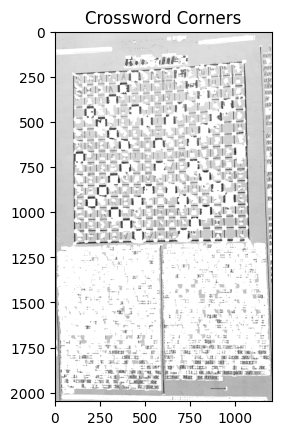

In [88]:
img = cv.imread('images/crossword.jpg', cv.IMREAD_GRAYSCALE)

corners = cv.cornerHarris(img, 22, 3, 0.18)

threshold = 0.0003

img[corners > threshold * corners.max()] = 255

plt.imshow(img, cmap='gray')
plt.title('Crossword Corners')
plt.show()

The combination of Canny edge detection and Harris corner detection enables us to segment different parts of images. This technique can be applied to various tasks such as counting blood cells in microscopic images, solving puzzles like sudoku and crosswords, analyzing chess positions, or detecting cracks and anomalies in various materials and road surfaces.

Don't forget to save your progress on GitHub!